In [6]:
from Classes import * 
from Simu import *
from NLL import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
import sympy as sy
from scipy import linalg
import pylab as pl
import math as ma
import time 
%matplotlib inline

# ---------- Fixés pour l'expérience -------------------
# Nombre de signaux longitudinaux
D=1
# Paramètres de variance pour la génération de paramètres du signal longitudinal
varu=1.
# Ecart-Type de l'erreur gaussienne des observations de Y
sigY=0.
# Numéro associé à la fonction paramètre génératrice
true_beta=beta(num=1)
numbeta=1
# Nombre de variables scalaires
p=1
# Options d'optimisation du critère d'inférence
opts0={'disp': True, 'maxiter': 120, 'gtol':200.}
# Taille de la grille d'évaluation de l'AMSE
nb=30
# Taille de la grille de tracé du graphe
sizegrid=50
# ---------- Variables de l'expérience -------------------
#vecN=[130,260,650]
#vecn=[10,100]
#vecgam=[0.,1.]
vecN=[260]
vecn=[10]
vecgam=[0.]
vecKb=[5]
vecJ=[100]
# Finir exp avec N 200,500, pour n =100, J=70 et rep=10
rep=10
rand_init=1
# Sauvegarde
save=False

vecRep=range(rep)
vecInit=range(rand_init)

candidats=[1,3,5,6]
N_modeles=10


Simu=expandnp([vecRep,vecN,vecn,vecgam])
Simu=Simu.astype(int)
N_Simu=len(Simu)
print("Design Simus")
print(" Rep   N  n  Erreur  n°Simu")
print(np.hstack((np.asarray(Simu),np.arange(N_Simu).reshape((N_Simu,1)))))

Exp=expandnp([vecInit,vecJ,vecKb,range(N_Simu)])
Exp=Exp.astype(int)
print("Design Params")
print("Init J Kbeta n°Simu")
print(np.asarray(Exp))
N_exp=len(Exp)
print(" Nombre d'inférences à réaliser : "+str(N_exp))
b_liste=[[] for i in range(N_exp) ]
messages=[[] for i in range(N_exp) ]
Jac=[[] for i in range(N_exp) ]
V_It_d_AMSE=np.zeros((6,N_modeles,N_exp),float)


Design Simus
 Rep   N  n  Erreur  n°Simu
[[  0 260  10   0   0]
 [  1 260  10   0   1]
 [  2 260  10   0   2]
 [  3 260  10   0   3]
 [  4 260  10   0   4]
 [  5 260  10   0   5]
 [  6 260  10   0   6]
 [  7 260  10   0   7]
 [  8 260  10   0   8]
 [  9 260  10   0   9]]
Design Params
Init J Kbeta n°Simu
[[  0 100   5   0]
 [  0 100   5   1]
 [  0 100   5   2]
 [  0 100   5   3]
 [  0 100   5   4]
 [  0 100   5   5]
 [  0 100   5   6]
 [  0 100   5   7]
 [  0 100   5   8]
 [  0 100   5   9]]
 Nombre d'inférences à réaliser : 10


# Simulation des jeux de données

In [7]:
t=sy.Symbol('t')
s=sy.Symbol('s')
# Nombre de variables scalaires
# Génération de Alpha et Z
Alpha=np.zeros(p,float)

l_T=[ [] for sim in range(N_Simu)]
l_L=[ [] for sim in range(N_Simu)]
l_Xdata=[ [] for sim in range(N_Simu)]
l_Y=[ [] for sim in range(N_Simu)]

for sim in range(N_Simu):
    N=Simu[sim,1]
    n_t_moy=Simu[sim,2]
    GammaX=Simu[sim,3]
    if float(sim)/20==round(sim/20):
        print("Simulation données n°"+str(sim)+" sur "+str(N_Simu))
    # ----------------- SIMULATION de DONNEES
    # Simulation des temps 
    (T,L,M_nt)=temps(N,D,n_t_moy)
    (U,V1,V2)=X_Params(varu,N,D)
    vec=np.reshape(M_nt,(N*D,1))
    # Exemple de signe vital simulé
    Z=np.zeros((N,p),float)
    txoxo=np.linspace(0,1,1000)
    X=X_fonc(txoxo,U[0,0],V1[0,0,:],V2[0,0,:])
    Xdata=X_obs(U,V1,V2,L,std=GammaX)
    (Y,C,Yc,Delta)=simu_YC(Alpha,true_beta,Z,U,V1,V2,T,sigY)
    (l_T[sim],l_L[sim],l_Xdata[sim],l_Y[sim])=(T,L,Xdata,Y)

if save:
    # Données
    str_longi='time,valeur,var,idv,simu'
    str_data='tmax,y,N,n,Err,rep,simu'
    lon=[ [ 0 for i in range(len(l_Y[k]))] for k in range(N_Simu)]
    tot=0
    for k in range(N_Simu):
        L=l_L[k]
        N=len(l_Y[k])
        for i in range(N):
            lon[k][i]=len(L[i][0])
            tot+=len(L[i][0])
    Longi=np.zeros((tot,5),float)
    print(Longi.shape)
    Data=np.zeros((sum(Simu[:,1]),7),float)
    print(Data.shape)
    n=0
    m=0
    for k in range(N_Simu):
        (L,Xdata,Y,T)=(l_L[k],l_Xdata[k],l_Y[k],l_T[k])
        N=len(Y)
        for i in range(N):
            Data[m,:]=(T[i],Y[i],N,Simu[k,2],Simu[k,3],Simu[k,0],k)
            m+=1
            for pt in range(lon[k][i]):
                Longi[n,:]=( L[i][0][pt] , Xdata[i][0][pt] , 0 , i , k)
                n+=1
    print(Data[0:5,:])
    print(Longi[0:5,:])
    np.savetxt("Longi.csv",Longi,delimiter=",",header=str_longi)
    np.savetxt("Data.csv",Data,delimiter=",",header=str_data)

Simulation données n°0 sur 10


# Récupération des données .csv et calcul des pré-matrices

In [ ]:
# Intro pandas
Longi=pd.read_csv("Longi.csv",header=0,names=['t','val','j','idv','simu'])
Data=pd.read_csv("Data.csv",header=0,names=['tmax','y','N','n','Err','rep','simu'])
print(Data.head())
#print(Longi.head())
#print(Data.iloc[[0,2],[2,3]])
#print(Data[(Data["simu"]==0)&(Data["tmax"]<0.45)])

       tmax         y     N     n  rep  simu
0  0.994923 -2.137893  50.0  10.0  0.0   0.0
1  0.965784 -0.533723  50.0  10.0  0.0   0.0
2  0.974744 -1.409542  50.0  10.0  0.0   0.0
3  0.669900 -0.563093  50.0  10.0  0.0   0.0
4  0.633200 -1.099333  50.0  10.0  0.0   0.0
          t       val    j  idv  simu
0  0.096176 -2.270143  0.0  0.0   0.0
1  0.170637 -4.488984  0.0  0.0   0.0
2  0.280406 -5.814404  0.0  0.0   0.0
3  0.329830 -6.856630  0.0  0.0   0.0
4  0.432847 -6.812442  0.0  0.0   0.0
      N     n
0  50.0  10.0
2  50.0  10.0
        tmax         y     N     n  rep  simu
6   0.415697  0.197003  50.0  10.0  0.0   0.0
13  0.386874 -0.744837  50.0  10.0  0.0   0.0
14  0.391514 -1.310681  50.0  10.0  0.0   0.0
22  0.431627 -2.012789  50.0  10.0  0.0   0.0
28  0.377850 -1.298604  50.0  10.0  0.0   0.0
31  0.407851  1.252076  50.0  10.0  0.0   0.0
35  0.288597 -1.149385  50.0  10.0  0.0   0.0
44  0.412160 -1.821409  50.0  10.0  0.0   0.0
46  0.403390 -0.867167  50.0  10.0  0.0   0.0


In [ ]:
nbsim=Data["simu"].unique().size

Params=expandnp([vecKb,vecJ])
numParam=len(Params[:,0])
deb=time.clock()
l_L=[ [] for sim in range(nbsim)]
l_Xdata=[ [] for sim in range(nbsim)]
l_T=[ [] for sim in range(nbsim)]
l_Y=[ [] for sim in range(nbsim)]
for simu in range(nbsim):
    #print("simu n°"+str(simu)+" sur "+str(nbsim-1)+" duree actuelle :"+str(time.clock()-deb))
    N=int(Data["N"][Data["simu"]==simu].iloc[0])
    l_Y[simu]=np.asarray( Data["y"][Data["simu"]==simu] )
    l_T[simu]=np.asarray( Data["tmax"][Data["simu"]==simu] )
    l_L[simu]=[ [[] for j in range(D) ]  for i in range(N) ]
    l_Xdata[simu]=[ [[] for j in range(D) ]  for i in range(N) ]
    Xda=Longi[Longi["simu"]==simu]
    for i in range(N):
        l_L[simu][i][0]=np.asarray( Xda["t"][Xda["idv"]==i] )
        l_Xdata[simu][i][0]=np.asarray( Xda["val"][Xda["idv"]==i] )

In [ ]:
ref_sim=-1
ref_Kb=-1
ref_J=-1
k=0
interrupteur=1
Res=pd.DataFrame(np.zeros((1,11),float), columns=['Init','J','Kbeta','sim','model','vrais','n_it','dur','emg','ise','sce'])
for Init,J,Kbeta,sim in Exp:
    k+=1
    if sim!=ref_sim:
        ref_sim=sim
        Rep=Simu[sim,0]
        N=Simu[sim,1]
        lim_learn=int(round(0.77*N))
        print("N learn ="+str(lim_learn))
        n_t_moy=Simu[sim,2]
        Err=Simu[sim,3]
        print("---------------------------- Simu n°"+str(sim)+" -> N ="+str(N)+"; n_moy ="+str(n_t_moy)+"Erreur ="+str(Err)+" Repetition ="+str(Rep))
        (T_full,L_full,Xdata_full,Y_full)=(l_T[sim],l_L[sim],l_Xdata[sim],l_Y[sim])
        ( T , L , Xdata , Y ) = (T_full[0:lim_learn],L_full[0:lim_learn],Xdata_full[0:lim_learn],Y_full[0:lim_learn])
        Y_test= Y_full[lim_learn:N]
        interrupteur=1
        Res.to_csv("Res.csv")
    print("Exp n°"+str(k)+" sur "+str(N_exp) +"-> N : "+str(N)+"; n_t_moy : "+str(n_t_moy)+"; Kbeta : "+str(Kbeta)+"; J : "+str(J))
    if Kbeta!=ref_Kb:
        ref_Kb=Kbeta
        print("---------------------------- Kbeta ="+str(Kbeta))
        Beta_fonc_est=construct_beta(Kbeta**2)
        interrupteur=1
    if J!=ref_J:
        ref_J=J
        print("---------------------------- J ="+str(J))
        interrupteur=1
    if interrupteur==1:
        (l_full,V_full,I_pen)=Pre_Comp(L_full,T_full,Xdata_full,Y_full,Kbeta,J)
        erreur=0
        ( Phi_mat,k_fonc_yx,k_der,I_pen_yx )=Pre_Comp_YX(L,T,Xdata,Y,Kbeta,J)
        (l,l_test) = ( l_full[0:lim_learn,:] , l_full[lim_learn:N,:] )
        ( V , V_test ) =( V_full[0:lim_learn] , V_full[lim_learn:N] )
        n_par=len(k_der)
        interrupteur=0
    print("Initialisation n°"+str(Init))
    b=np.random.uniform(-10,10,D*Kbeta**2)
    (Z,Z_test)=( np.zeros((lim_learn,p),float) , np.zeros((N-lim_learn,p),float) ) 
    print("std Y ="+str(np.std(Y)))
    for mod in candidats:
        emg=0.
        n_it=0.
        try:
            if mod==0:
                # --------------------------MODELE 0 Estimateur MC Classique ------------
                deb=time.clock()
                bf=MCO_best(l,Y)
                Pf=np.concatenate((np.zeros(p,float),bf))
                dur=time.clock()-deb 
                rmse=rMSE( Pred_YlX(Pf,Z_test,l_test) , Y_test )
            if mod==1:
                # --------------------------MODELE 1 Estimateur MC pénalisé ------------
                deb=time.clock()
                a=MCO_pen_learn(Z,l,Y,I_pen,n_test=10)
                Lambda=a[2]
                bf=MCO_pen_best(l,Y,I_pen,Lambda)
                Pf=np.concatenate((np.zeros(p,float),bf))
                dur=time.clock()-deb 
                rmse=rMSE( Pred_YlX(Pf,Z_test,l_test) , Y_test )
            if mod==2:
                # --------------------------MODELE 2 Estimateur MC+pénalitévariance ------------
                deb=time.clock()
                bf=MCO_penvar_best(V,l,Y)
                Pf=np.concatenate((np.zeros(p,float),bf))
                dur=time.clock()-deb 
                rmse=rMSE( Pred_YlX(Pf,Z_test,l_test) , Y_test )
            if mod==3:
                # --------------------------MODELE 3 Estimateur MC+double pénalité ------------
                deb=time.clock()
                a=MCO_2pen_learn(Z,V,l,Y,I_pen,n_test=10)
                Lambda=a[2]
                bf=MCO_2pen_best(Z,V,l,Y,I_pen,Lambda)
                Pf=np.concatenate((np.zeros(p,float),bf))
                dur=time.clock()-deb 
                rmse=rMSE( Pred_YlX(Pf,Z_test,l_test) , Y_test )
            if mod==4:
                # --------------------------MODELE 4 L_YlX pénalisé ------------
                Lambda=N*1./(Kbeta**2)
                deb=time.clock()
                (Pf,Vf,Gf,vrais)=LYlX_optim(L_YlX_pen,Z,l,V,Y,I_pen,Lambda,n_it=200,n_ini=10,tol=0.5)
                dur=time.clock()-deb 
                rmse=rMSE( Pred_YlX(Pf,Z_test,l_test) , Y_test )
                emg=np.sqrt( Gf.dot(Gf)/len(Gf))
            if mod==5:
                # --------------------------MODELE 5 L_YlX pénalisé stochastique ---------------------
                deb=time.clock()
                a=LYlX_learn(Z,V,l,Y,I_pen,n_it=N*20,n_ini=4,tol=0.5,n_test=10)
                Lambda=a[2]
                (Pf,Vf,Gf,vrais)=LYlX_optim(S_L_YlX_pen,Z,l,V,Y,I_pen,Lambda,n_it=200*N,n_ini=5,tol=0.5)
                dur=time.clock()-deb 
                rmse=rMSE( Pred_YlX(Pf,Z_test,l_test) , Y_test )
                emg=np.sqrt( Gf.dot(Gf)/len(Gf))
            if mod==6:
                #-------------------------- MODELE 6 LYX stochastique pénalisé
                deb=time.clock()
                a=LYX_learn(Z,l,L,T,Xdata,Y,Phi_mat,k_fonc_yx,k_der,I_pen,n_it=N*5,n_ini=2,tol=0.5,n_test=5)
                Lambda=a[2]
                (Pf,Vf,Gf,vrais)=LYX_optim(Z,l,L,T,Xdata,Y,Phi_mat,k_fonc_yx,k_der,I_pen,Lambda,
                                           n_it=30*N,n_ini=3,tol=0.5)
                dur=time.clock()-deb
                rmse=rMSE( Pred_YlX(Pf[0:(D*Kbeta**2+p)],Z_test,l_test) , Y_test )
                emg=np.sqrt( Gf.dot(Gf)/len(Gf))

            #--------------- STOCKAGE    
            Vrais_ref=L_YlX(Pf[0:(D*Kbeta**2+p)],Z,V,l,Y,D)[0]
            b_l=Pf[p:(p+Kbeta**2)]
            emb=np.sqrt(b_l.dot(b_l)/len(b_l))
            b_learned=b_l.reshape((D,Kbeta**2)).T
            ise=ISE(numbeta,Beta_fonc_est,b_learned,T,nb=30)
            if mod in [0,1,2,3]:
                Vf=Vrais_ref
            print(str(mod)+" Vf :"+str(Vf)+" rMSE :"+str(rmse)+" EMG :"+str(emg)+" duree :"+str(dur)+" ISE :"+str(ise)+" EMb :"+str(emb) )
            Res=Res.append({'Init':Init,'J':J,'Kbeta':Kbeta,'sim':sim,'model':mod,'vrais':Vf,'n_it':n_it,'dur':dur,'emg':emg,'ise':ise,'rmse':rmse},ignore_index=True)
        except:
            #--------------- STOCKAGE    
            print(str(mod)+" ->Erreur dans l'inférence")
            Res=Res.append({'Init':Init,'J':J,'Kbeta':Kbeta,'sim':sim,'model':mod,'vrais':float('nan'),'n_it':float('nan'),'dur':float('nan'),'emg':float('nan'),'ise':float('nan'),'rmse':float('nan')},ignore_index=True)
            pass
    print("")
    
    

N learn =200
---------------------------- Simu n°0 -> N =260; n_moy =10Erreur =0 Repetition =0
Exp n°1 sur 10-> N : 260; n_t_moy : 10; Kbeta : 5; J : 100
---------------------------- Kbeta =5
---------------------------- J =100
Initialisation n°0
std Y =1.05997412168
ISE : 9.27597945331
1 Vf :152.557715845 rMSE :0.745869591497 EMG :0.0 duree :0.020131 ISE :9.27597945331 EMb :0.132683205358
ISE : 9.04003945627
3 Vf :153.319128565 rMSE :0.747141403011 EMG :0.0 duree :1.178794 ISE :9.04003945627 EMb :0.081043690036
ISE : 9.1392677025
5 Vf :200.290701864 rMSE :0.761023234463 EMG :100.844891365 duree :61.259199 ISE :9.1392677025 EMb :0.131116472131
ISE : 9.25041373972
6 Vf :3521.92792955 rMSE :0.745836822599 EMG :7.40911229319 duree :917.310564 ISE :9.25041373972 EMb :0.127154018952

N learn =200
---------------------------- Simu n°1 -> N =260; n_moy =10Erreur =0 Repetition =1
Exp n°2 sur 10-> N : 260; n_t_moy : 10; Kbeta : 5; J : 100
Initialisation n°0
std Y =1.02615473291
ISE : 8.53116974

In [4]:
a=MCO_pen_learn(Z,l,Y,I_pen,n_test=3)
print(a[1])
print(np.sqrt(Y.dot(Y)/len(Y)))

a=MCO_2pen_learn(Z,V,l,Y,I_pen,n_test=3)
print(a[1])

a=LYlX_learn(Z,V,l,Y,I_pen,n_it=N*10,n_ini=10,n_test=3)
print(a[1])

a=LYX_learn(Z,l,L,T,Xdata,Y,Phi_mat,k_fonc_yx,k_der,I_pen,n_it=N*5,n_ini=2,tol=0.5,n_test=3)
print(a[1])

1.0168201523
1.0909341385
0.89050012982
0.829234040402
passage :1.770195 sec
passage :34.261663 sec
passage :80.645406 sec
116.691318
0.945049903003


In [ ]:
def LYlX_pen_learn(function,Z,V,l,Y,I_pen):
    N=len(V)
    Lambda=N*np.logspace( -5. , 3.0, num=20)
    print(Lambda)
    rmse=[ 0. for i in range(len(Lambda))]
    Res=[ [] for i in range(len(Lambda))]
    n_learn=int(round(0.7*N))
    for i in range(len(Lambda)):
        (ind_learn,ind_test)=parmi(n_learn,N)
        
        (Z_learn , Z_test ) = ( Z[ind_learn,:],Z[ind_test,:] )
        (l_learn , l_test ) = ( l[ind_learn,:],l[ind_test,:] )
        ( Y_learn , Y_test ) = ( Y[ind_learn] , Y[ind_test] )
        V_learn=[ [] for j in range(n_learn) ]
        for j in range(n_learn):
            V_learn[j]=V[ind_learn[j]]
        Res[i]=function( Z_learn,V_learn, l_learn,Y_learn,I_pen,Lambda[i] )
        rmse[i] = rMSE( Pred_YlX( Res[i] , Z_test, l_test ), Y_test )
    
    which_min=[ x for x in range(len(Lambda)) if rmse[x]==np.nanmin(rmse)][0]
    return  (Res[which_min],rmse[which_min],Lambda[which_min]);

In [2]:
Exp_res=expandnp([range(N_modeles),vecInit,vecJ,vecKb,range(N_Simu)])
Exp_res=Exp_res.astype(float)
lon=len(Exp_res)
print(lon)
Res=np.zeros((lon,6),float)
Exp_res_=np.hstack((Exp_res,Res))
head=['Modele','Init','J','Kbeta','Simulation','Vraisemblance','Iterations','Duree','Std_gradient','Ise','Sce']
str_head=''
for i in range(len(head)):
    if i==0:
        str_head=str_head+head[i]
    else:
        str_head=str_head+','+head[i]
print(Exp_res_.shape)
print(Exp_res_[0:5,:])
k=0
for i in range(N_exp):
    for Modele in range(N_modeles):
        Exp_res_[k,5:11]=V_It_d_AMSE[:,Modele,i]
        k+=1
print(str_head)
print(Exp_res_[0:5,:])
np.savetxt("Res.csv",Exp_res_,delimiter=",",header=str_head)


list

In [12]:



# Données
str_longi='time,valeur,var,idv,simu'
str_data='tmax,y,N,n,rep,simu'

lon=[ [ 0 for i in range(len(l_Y[k]))] for k in range(N_Simu)]
tot=0
for k in range(N_Simu):
    L=l_L[k]
    N=len(l_Y[k])
    for i in range(N):
        lon[k][i]=len(L[i][0])
        tot+=len(L[i][0])
Longi=np.zeros((tot,5),float)
print(Longi.shape)
Data=np.zeros((sum(Simu[:,1]),6),float)
print(Data.shape)
n=0
m=0
for k in range(N_Simu):
    (L,Xdata,Y,T)=(l_L[k],l_Xdata[k],l_Y[k],l_T[k])
    N=len(Y)
    for i in range(N):
        Data[m,:]=(T[i],Y[i],N,Simu[k,2],Simu[k,0],k)
        m+=1
        for pt in range(lon[k][i]):
            Longi[n,:]=( L[i][0][pt] , Xdata[i][0][pt] , 0 , i , k)
            n+=1
print(Data[0:5,:])
print(Longi[0:5,:])
np.savetxt("Longi_1808.csv",Longi,delimiter=",",header=str_longi)
np.savetxt("Data_1808.csv",Data,delimiter=",",header=str_data)

1620
(1620L, 11L)
[[  0.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  2.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  3.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  4.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]]
Modele,Init,J,Kbeta,Simulation,Vraisemblance,Iterations,Duree,Std_gradient,Ise,Sce
[[  0.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  2.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  3.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]
 [  4.   0.  80.  10.   0.   0.   0.   0.   0.   0.   0.]]
(42352L, 5L)
(5100L, 6L)
[[   0.5229981    10.04371502  200.           15.            0.            0.        ]
 [   0.51102968    2.93424119  200.           15.            0.            0.        ]
 [   0.64751643    5.02277397  200.           15.            0.            0.        ]
 [   0.46849434  -19.52339976  

N: 500
Ecart moyen b :1.2898111267 Vrais 1236.56521843 Ecart moyen gradient :842.944078852
Ecart moyen b :1.38828239828 Vrais 250.797872889 Ecart moyen gradient :1373.6290142
Ecart moyen b :2.17872496563 Vrais 316.773215961 Ecart moyen gradient :274.361519799
Ecart moyen b :2.74486977543 Vrais 110.453713968 Ecart moyen gradient :16.7373029628
Ecart moyen b :3.19712984114 Vrais 224.525751861 Ecart moyen gradient :1425.63799844
Ecart moyen b :3.61151187206 Vrais 149.38288154 Ecart moyen gradient :23513.0174357
Ecart moyen b :6.17917470068 Vrais 311.844370521 Ecart moyen gradient :404.18194869
Ecart moyen b :6.20040895911 Vrais 103.106657637 Ecart moyen gradient :60.9043699747
Ecart moyen b :6.20073702358 Vrais 161.262183555 Ecart moyen gradient :3965.07115816
Ecart moyen b :6.4245649643 Vrais 247.287400198 Ecart moyen gradient :10015.2790537
Ecart moyen b :6.64151075026 Vrais 502.231838338 Ecart moyen gradient :12390.7672969
Ecart moyen b :6.8511255876 Vrais 381.767279356 Ecart moyen gra

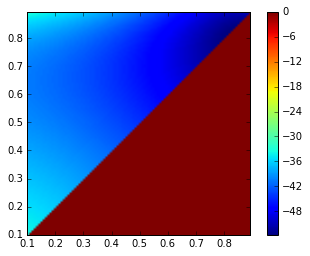

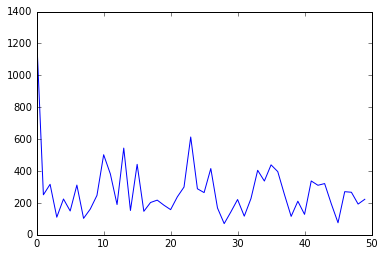

In [75]:
Xdata=l_Xdata[10]
L=l_L[10]
Y=l_Y[10]
T=l_T[10]
N=len(T)
print("N: "+str(N))
Kbeta=10
J=50
Z=np.zeros((N,p),float)
np.set_printoptions( precision=2, linewidth=200)
(Phi_mat,k_fonc,k_der,I_pen)=Pre_Comp_YX(L,T,Xdata,Y,Kbeta,J)
Lambda=2.
n_par=len(k_der)
Po=np.zeros( N*D*(2+n_par)+Kbeta**2+p,float )
Po[0:p]= np.zeros( p, float )
Po[p:(D*Kbeta**2+p)]= np.random.uniform(-10,10,D*Kbeta**2)
Po[(D*Kbeta**2+p):(N*D+D*Kbeta**2+p)]=np.zeros( D*N, float )
Po[(N*D+D*Kbeta**2+p):(2*N*D+D*Kbeta**2+p)]=np.ones( D*N, float )
Po[(2*N*D+D*Kbeta**2+p):((2+n_par)*N*D+D*Kbeta**2+p)]=np.ones( n_par*D*N, float )

args={'Z':Z,'L':L,'T':T,'Xdata':Xdata,'Y':Y,'Phi_mat':Phi_mat,'k_fonc':k_fonc_yx,'k_der':k_der,'Stochastic':True,'I_pen':I_pen,'Lambda':Lambda}
deb=time.clock()
(Pf,Vf,Gf,vrais)=GD_new( L_YX , Po , args, func_V=True, max_it=50 ,reach=2 ,depth=12 ,verbose=True )
dur=time.clock()-deb
print("duree :"+str(dur))
b_learned=Pf[p:(p+Kbeta**2)].reshape((D,Kbeta**2)).T
ise=ISE(true_beta,b_learned,T,nb=30,plot_beta=True,resolution=100)

fig2 = plt.figure().add_subplot(111)
delais=0
fig2.plot(np.arange(len(vrais)-delais),np.asarray(vrais[delais:len(vrais)]))

print(Pf[(2*N*D+D*Kbeta**2+p):((2+n_par)*N*D+D*Kbeta**2+p)])

## Avec Gradient Descent


b = [ 0.1669602   0.07790252  0.58974635  0.96612315  0.99641002  0.64951979
 -0.05552675 -0.68646649  0.36263361 -0.18628189 -0.79097571 -0.45511505
  0.13610608 -0.11456627  0.33683096 -0.41976699  0.15151141 -0.94485331
 -0.96799119  0.65661064  0.10683005  0.60474519 -0.89919284  0.38885394
  0.35325015 -0.60009967 -0.76861358 -0.96976638  0.50854403  0.99054269
  0.32617398 -0.22963766  0.30487167  0.5839736   0.85352455  0.55065626
  0.51153234  0.96715986  0.01147372 -0.79896059  0.98346763 -0.83899792
  0.08703202  0.10429265  0.52007875 -0.69152948  0.61864778 -0.15145094
 -0.44947469 -0.29662348 -0.3281532  -0.78555541 -0.15483172 -0.88091353
 -0.63435636 -0.10792614  0.18805966 -0.00350117 -0.36961833 -0.23920585
 -0.22812558  0.62719218  0.68034184 -0.04054716  0.90979397 -0.02957766
 -0.41348521  0.38571289  0.65161916 -0.57736116  0.22225007 -0.80127355
  0.88955204 -0.19102565 -0.86538166 -0.96838029 -0.76684597 -0.58135929
 -0.6427335  -0.99086065 -0.88187051  0.2497814

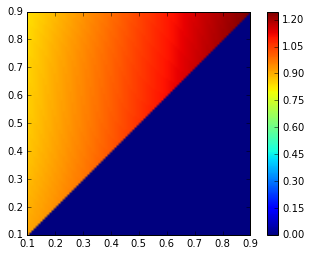

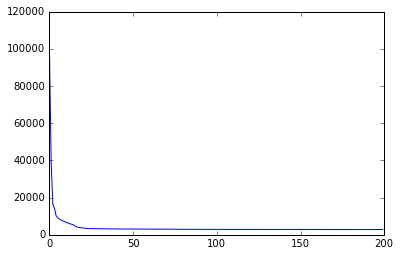

In [11]:
Xdata=l_Xdata[0]
L=l_L[0]
Y=l_Y[0]
T=l_T[0]
N=len(T)

Kbeta=5
J=70

(l,V,I_pen)=Pre_Comp(L,T,Xdata,Y,Kbeta,J)
Lambda=1.
Z=np.zeros((N,p),float)
for i in range(5):
    b=np.random.uniform(-1,1,D*Kbeta**2)
    print("b = "+ str(b))
    Po=np.concatenate( ( Alpha.reshape(-1), (b.T).reshape(-1)) )
    args=[Z,V,l,Y,D,I_pen,Lambda]
    #(Pf,Vf,Gf,vrais)=GD( S_L_YlX_pen_noC_fast , Po , args,max_it=200 ,reach=5 ,depth=15 ,verbose=False )
    (Pf,Vf,Gf,vrais)=GD( L_YlX_pen_noC_fast , Po , args,max_it=120 ,reach=10 ,depth=25 ,verbose= False)
    # --- AMSE
    b_learned=Pf[p:(p+Kbeta**2)].reshape((D,Kbeta**2)).T
    ise=ISE(true_beta,b_learned,T,nb=30,plot_beta=True,resolution=100)

    fig2 = plt.figure().add_subplot(111)
    delais=0
    fig2.plot(np.arange(len(vrais)-delais),np.asarray(vrais[delais:len(vrais)]))



Expérience de simulation pour tester les performances de convergence et la qualité d'estimation du modèle. Pour cela on fait varier :  N , n_moy, Kbeta, J (la finesse de la maille doit être suffisante pour permettre à l'algo d'optim de bien converger) avec des répétitions (jeux de données sont parfois pas faciles) et en lancant l'optim plusieurs fois pour chaque combinaison. On utilise un critère de performance AMSE (Average Mean-Square Error) évaluer la qualité d'estimation du paramètre fonctionnel $\beta(s,T)$, ainsi que l'écart-type de prédiction par rapport au vrai label sur un jeu de données test non utilisé pour l'inférence (30$\%$ des données simulées).

In [4]:
T=1
sizegrid=150
x=np.linspace( 0.1, np.max(T), num=sizegrid)
y=np.linspace( 0.1, np.max(T), num=sizegrid)
arr=[x,y]
Grid=expandnp(arr)
x=Grid[:,0]
y=Grid[:,1]
arrV=np.zeros(sizegrid**2,float)
n=0
for i in range(sizegrid):
    for j in range(sizegrid):
        if j<=i:
            arrV[n] = true_beta.val([x[n],y[n]])
        n+=1
Xfig=x.reshape((sizegrid,sizegrid))
Yfig=y.reshape((sizegrid,sizegrid))
Zfig=arrV.reshape((sizegrid,sizegrid))
figure(figsize = (20,2))
fig=plt.figure().add_subplot(111)
string="Exp "+str(k)+" sur "+str(N_exp) +"-> N : "+str(N)+"; n_t_moy : "+str(n_t_moy)+"; Kbeta : "+str(Kbeta)+"; J : "+str(J)+" => AMSE : "+str(amse)
plt.title(string)
plt.imshow(Zfig, vmin=Zfig.min(), vmax=Zfig.max(), origin='lower',
           extent=[ Yfig.min(), Yfig.max(),Xfig.min(),Xfig.max()])
plt.colorbar()

NameError: name 'true_beta' is not defined

## Echantillonnage de l'AMSE

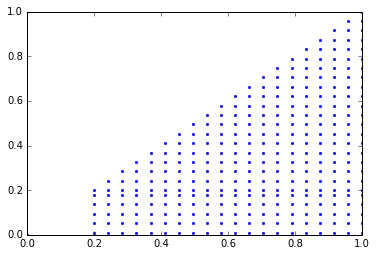

In [22]:
nb=20
Tmax=1
Tmin=0.2
Tgrid=np.linspace(Tmin,Tmax,nb,retstep=True)
step=Tgrid[1]
Tgrid=Tgrid[0]
tgrid_min=np.arange(0.01,Tmin,step,float)
grille=np.vstack((Tgrid,np.arange(nb)))
count=0
t_liste=[0.,0.]
T_liste=[0.,0.]

for T_,i in grille.T:
    for t_ in np.concatenate( (tgrid_min,grille[0,0:(int(i)+1)]) ):
        t_liste.append(t_)
        T_liste.append(T_)

fig2 = plt.figure().add_subplot(111)
fig2.plot(T_liste,t_liste,marker=".",markersize=5,linestyle="none")

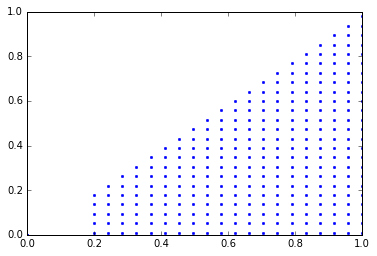

In [23]:
nb=20
Tmax=1
Tmin=0.2
Tgrid=np.linspace(Tmin,Tmax,nb,retstep=True)
step=Tgrid[1]
Tgrid=Tgrid[0]
grille=np.vstack((Tgrid,np.arange(nb)))
count=0
t_liste=[0.,0.]
T_liste=[0.,0.]

for T_,i in grille.T:
    for t_ in np.arange( 0.01,T_,step,float ):
        t_liste.append(t_)
        T_liste.append(T_)

fig2 = plt.figure().add_subplot(111)
fig2.plot(T_liste,t_liste,marker=".",markersize=5,linestyle="none")

# Algorithme de descente de gradient

In [4]:
data=0

Xdata=l_Xdata[data]
L=l_L[data]
T=l_T[data]
Y=l_Y[data]
k_foncs=l_k_foncs[data]
Psi=l_Psi[data]
moy_est=l_moy_est[data]
N=len(T)
D=len(L[0])
Kbeta=10
J=60

# ----------------- Construction de la base fonctionnelle 
syPhi=sy.ones(Kbeta**2,1)
syb=sy.ones(1,Kbeta**2)
v=[np.arange(Kbeta),np.arange(Kbeta)]
expo=expandnp(v)
Phi_fonc=[ [] for j in range(Kbeta**2) ]
for x in range(len(expo[:,0])):
    syPhi[x]=(t**expo[x,0])*(s**expo[x,1])
    Phi_fonc[x]=sy.lambdify((t,s),syPhi[x],'numpy')
    syb[x]=sy.Symbol('b'+str(x))
syBeta=syb*syPhi

Alpha=np.zeros(p,float)

# Phi_mat
Phi_mat=Comp_Phi(Phi_fonc,T,J)
(Is,Ic,It,I_pen)=J22_fast(syPhi,np.max(T),50)
Lambda=1.
print(I_pen[0:5,0:5])

2.82321951404 secondes de calcul
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          2.07982013  2.07982013  2.07982013]
 [ 0.          0.          2.07982013  3.18184963  3.18184963]
 [ 0.          0.          2.07982013  3.18184963  5.29312183]]


b = [ 0.83878391 -0.55648278  0.79571226  0.05645171 -0.37054582 -0.26655525
 -0.27636702 -0.68297327 -0.7727995   0.30930873  0.80508074  0.08500918
 -0.06986258  0.58846898  0.18500972 -0.90397698  0.8730011  -0.57291237
 -0.14756024  0.20609255 -0.55675236  0.86535977  0.91991469  0.69892063
  0.97136485  0.52189938 -0.16520775 -0.75519763 -0.64962205  0.27571637
  0.06159175  0.20805808  0.86769022  0.26937494 -0.78435082 -0.18112137
  0.64905783  0.15203491 -0.01370615 -0.14498085 -0.64670761  0.82012376
 -0.09422324 -0.95756741 -0.06933978 -0.37527388  0.14927147 -0.20488551
  0.59353162  0.47697604  0.59460937 -0.74033342  0.75433142 -0.15908192
 -0.05705657  0.68426186 -0.9602171   0.59208457 -0.07298217  0.76092041
 -0.29789872  0.62547822  0.42311238 -0.54298784 -0.7046387   0.64879399
 -0.62698667  0.00982757 -0.12979555  0.41778508  0.57204653 -0.4457053
 -0.09792413 -0.82300544 -0.18483377  0.87225775  0.17184932  0.20269891
 -0.19046136  0.43403707 -0.74930093  0.43062622

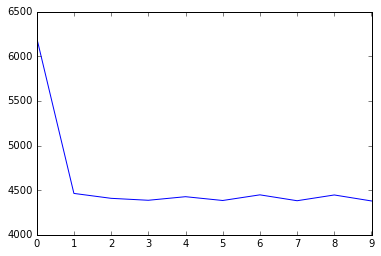

In [28]:
Z=np.zeros((N,p),float)
b=np.random.uniform(-1,1,D*Kbeta**2)
print("b = "+ str(b))
Pn=np.concatenate( ( Alpha.reshape(-1), (b.T).reshape(-1)) )
args=[Z,L,T,Xdata,Y,Phi_mat,k_foncs,Psi,moy_est]
(Pf,Vf,Gf,vrais)=GD_switch(L_YlX_noC,Pn,args,max_it=10,verbose=True)

# --- AMSE
b_learned=Pf[p:(p+Kbeta**2)].reshape((D,Kbeta**2)).T
Beta_fonc_est=[ [] for j in range(D)]
for j in range(D):
    replacements= [ (sy.Symbol('b'+str(x)),b_learned[x,j]) for x in range(Kbeta**2)]
    syBeta_subs=syBeta.subs(replacements)[0]
    Beta_fonc_est[j]=sy.lambdify((t,s),syBeta_subs,'numpy')

amse=0.
Tmax=np.max(T)
Tmin=np.min(T)
Tgrid=np.linspace(Tmin,Tmax,nb,retstep=True)
step=Tgrid[1]
Tgrid=Tgrid[0]
grille=np.vstack((Tgrid,np.arange(nb)))
count=0
for T_,i in grille.T:
    for t_ in np.arange( 0.01,T_,step,float ):
        count+=1
        true_b=true_beta.val([t_,T_])
        est_b=Beta_fonc_est[0](t_,T_)
        amse= amse + (true_b - est_b )**2
amse=amse/count
print("AMSE : "+str(amse))

fig2 = plt.figure().add_subplot(111)
delais=0
print(np.asarray(vrais))
fig2.plot(np.arange(len(vrais)-delais),np.asarray(vrais[delais:len(vrais)]))


Norme b 5.78140253044 Vrais 18082.2172472 ecart moyen à 0 dans gradient : 597.308276869
Norme b 6.42909286416 Vrais 71997.8568599 ecart moyen à 0 dans gradient : 443.047989511
Norme b 5.77899346089 Vrais 17961.0950134 ecart moyen à 0 dans gradient : 534.831272487
Norme b 5.77425904871 Vrais 6090.2059088 ecart moyen à 0 dans gradient : 263.671478674
Norme b 5.7764516851 Vrais 2512.52193776 ecart moyen à 0 dans gradient : 56.1391710995
AMSE : 7.64187575207
[ 18082.21724718  71997.85685985  17961.09501344   6090.2059088
   2512.52193776]


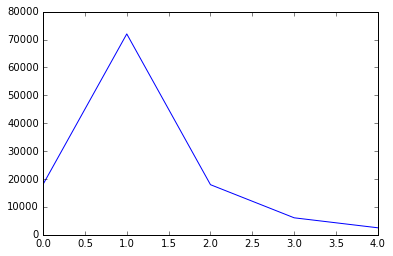

In [15]:
args=[Z,L,T,Xdata,Y,Phi_mat,k_foncs,Psi,moy_est,I_pen,Lambda]
(Pf,Vf,Gf,vrais)=GD_switch(L_YlX_pen_noC,Pn,args,max_it=5,verbose=True)

# --- AMSE
b_learned=Pf[p:(p+Kbeta**2)].reshape((D,Kbeta**2)).T
Beta_fonc_est=[ [] for j in range(D)]
for j in range(D):
    replacements= [ (sy.Symbol('b'+str(x)),b_learned[x,j]) for x in range(Kbeta**2)]
    syBeta_subs=syBeta.subs(replacements)[0]
    Beta_fonc_est[j]=sy.lambdify((t,s),syBeta_subs,'numpy')

amse=0.
Tmax=np.max(T)
Tmin=np.min(T)
Tgrid=np.linspace(Tmin,Tmax,nb,retstep=True)
step=Tgrid[1]
Tgrid=Tgrid[0]
grille=np.vstack((Tgrid,np.arange(nb)))
count=0
for T_,i in grille.T:
    for t_ in np.arange( 0.01,T_,step,float ):
        count+=1
        true_b=true_beta.val([t_,T_])
        est_b=Beta_fonc_est[0](t_,T_)
        amse= amse + (true_b - est_b )**2
amse=amse/count
print("AMSE : "+str(amse))

fig2 = plt.figure().add_subplot(111)
delais=0
print(np.asarray(vrais))
fig2.plot(np.arange(len(vrais)-delais),np.asarray(vrais[delais:len(vrais)]))
